In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model


5872.800591009329


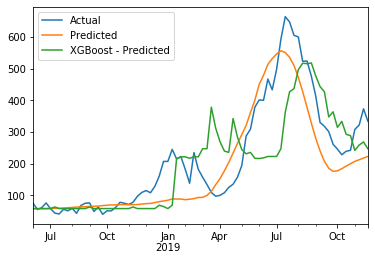

In [14]:
#Applying 1st Layer of XGBoost
df = pd.read_csv("Processed_Data.csv",index_col = 0)
train = df[:"2018-06"]
test = df["2018-06":]
max_lookback = 55
pred_interval = 8 
input_len = max_lookback - pred_interval
X_train =[]
y_train = [] 
for i in range(len(train)-max_lookback):

    X_train.append(train.iloc[i:i+max_lookback-pred_interval,2])
    y_train.append(train.iloc[i+max_lookback,2])
X_train, y_train = np.array(X_train),np.array(y_train)
inputs = df.iloc[len(df) - len(test) - max_lookback:,2]
X_test = []
y_test = []
for i in range(len(inputs) - max_lookback):
    X_test.append(inputs[i:i+max_lookback-pred_interval])
    y_test.append(inputs[i+max_lookback])
X_test = np.array(X_test)
xgb = XGBRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 50,
                  objective = "reg:squarederror",verbosity= 0)
xgb.fit(X_train,y_train)
pred = xgb.predict(X_train)
pred_test = xgb.predict(X_test)
df2 = pd.DataFrame(pred,index = train.iloc[max_lookback:].index,
                  columns = ["xgb"])
df2 = pd.concat([df2,train],axis =1,sort = True)
df2.loc[df2["xgb"].isna(),"xgb"] = df2[df2["xgb"].isna()]["dengue"]
df2.index = pd.to_datetime(df2.index)
sc2 = MinMaxScaler()
train1 = sc2.fit_transform(df2)
max_lookback = 45
model = load_model("models/16 Pass.h5")
df3 = pd.DataFrame(pred_test,index = test.index,
                  columns = ["xgb"])
df3 = pd.concat([test,df3],axis = 1)
cols = df3.columns.to_list()
cols = [cols[-1]] + cols[:-1]
df3 = df3[cols]
df3.index = pd.to_datetime(df3.index)
df2 = pd.concat([df2,df3],axis = 0, sort = True)
df2 = df2[cols]
input_len = max_lookback - 8
inputs = df2.iloc[len(df2) - len(test) - input_len:]
inputs = sc2.transform(inputs)
X_test = []
for i in range(len(inputs) - input_len):
    X_test.append(inputs[i:i+input_len,:-1])
X_test= np.array(X_test)
pred = model.predict(X_test)
actual = test["dengue"].values
pred = np.concatenate([np.zeros((pred.shape[0],3)),pred],axis = 1)
results  = sc2.inverse_transform(pred)
error = actual - results[:,-1]
vis = pd.DataFrame([actual,results[:,-1],pred_test])
vis = vis.T
vis.columns = ["Actual","Predicted","XGBoost - Predicted"]
vis.index = test.index
vis.index = pd.to_datetime(vis.index)
vis.plot()
print(np.mean(np.square(error)))

In [ ]:
# Saving XGB Regressor
import pickle
#pickle.dump(xgb, open("xgb.pickle.dat", "wb"))
xgb = pickle.load(open("xgb.pickle.dat", "rb"))